# NN Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import tensorflow as tf
from tensorflow import keras

## Pre-processing

Load and pre-process the dataset:

In [4]:
from lib import pre_processing
file_path = "./data/features_3_sec.csv"
df = pd.read_csv(file_path)
df = pre_processing(df)

## Data Normalization

In [5]:
from lib import normalize_df
df = normalize_df(df)

In [6]:
df_numpy = df.to_numpy()
X = df_numpy[:,:-1].astype(np.float32)
y = df_numpy[:, -1]

In [7]:
X.shape, y.shape

((9990, 57), (9990,))

## Label pre-processing

In [8]:
from lib import encode_labels
y_ohe = encode_labels(y)

In [9]:
X.shape, y_ohe.shape

((9990, 57), (9990, 10))

# Loading the models

The models were already created and saved in another notebook.

Here we just have to load them.

In [10]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [11]:
models = { genre: keras.models.load_model('models/' + genre) for genre in genres }
models['multiclass'] = keras.models.load_model('models/multiclass')
models

{'blues': <keras.engine.sequential.Sequential at 0x7f1df549bdc0>,
 'classical': <keras.engine.sequential.Sequential at 0x7f1df5dc76a0>,
 'country': <keras.engine.sequential.Sequential at 0x7f1de0094fd0>,
 'disco': <keras.engine.sequential.Sequential at 0x7f1d840a3d00>,
 'hiphop': <keras.engine.sequential.Sequential at 0x7f1d7c0be730>,
 'jazz': <keras.engine.sequential.Sequential at 0x7f1d54317730>,
 'metal': <keras.engine.sequential.Sequential at 0x7f1d542280a0>,
 'pop': <keras.engine.sequential.Sequential at 0x7f1d54071520>,
 'reggae': <keras.engine.sequential.Sequential at 0x7f1d38237c40>,
 'rock': <keras.engine.sequential.Sequential at 0x7f1d382a1460>,
 'multiclass': <keras.engine.sequential.Sequential at 0x7f1d38237e50>}

## Model Evaluation

In [12]:
from sklearn.model_selection import train_test_split

def predict_multi(X, y, test_size, model):
    # Train-validation split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    
    # Compute predictions
    y_pred = np.rint(model(X_test).numpy())
    
    # Return the accuracy
    return ((y_test == y_pred).sum() / (y_test.shape[0] * y_test.shape[1]))

In [13]:
def predict_binary(X, y, test_size, model):
    # Train-validation split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    
    # Compute predictions
    y_pred = np.rint(model(X_test).numpy())
    y_pred = np.reshape(y_pred, len(y_test))
    
    # Return the accuracy
    return ((y_test == y_pred).sum() / len(y_test))

In [14]:
from sklearn.model_selection import KFold

def cross_validate_multi(X, y, n_splits, model):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    accuracy_list = []
    
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        y_pred = np.rint(model(X_test).numpy())
        accuracy = (y_test == y_pred).sum() / (y_test.shape[0] * y_test.shape[1])
        accuracy_list.append(accuracy)
        
    return np.mean(accuracy_list)

In [15]:
def cross_validate_binary(X, y, n_splits, model):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    accuracy_list = []
    
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        y_pred = np.rint(model(X_test).numpy())
        y_pred = np.reshape(y_pred, len(y_test))
        accuracy = (y_test == y_pred).sum() / len(y_test)
        accuracy_list.append(accuracy)
        
    return np.mean(accuracy_list)

## Static partitioning (train-validation split)

In [16]:
test_sizes = [0.1, 0.25, 0.33]

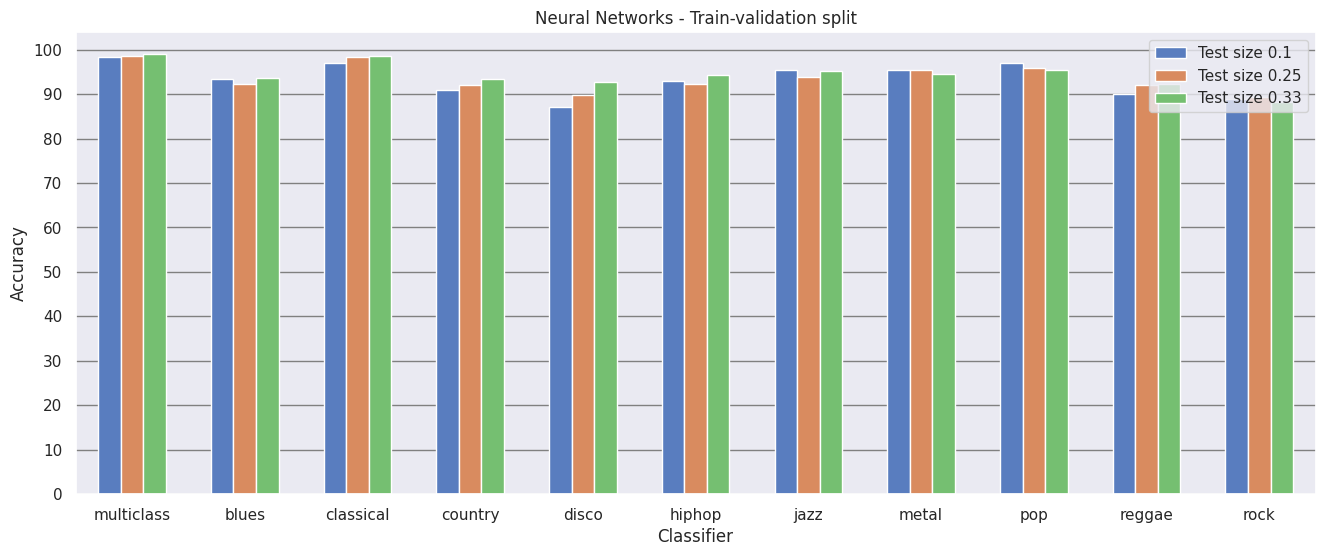

In [17]:
from lib import plot_evaluation_results, balance_classes
sp_results = []

for test_size in test_sizes:
    # Multiclass classifier
    accuracy = predict_multi(X, y_ohe, test_size, models['multiclass'])
    sp_results.append(('multiclass', accuracy*100, f'Test size {test_size}'))
    
    # Binary classifiers
    for genre in genres:
        Xi, yi = balance_classes(X, y, genre)
        accuracy = predict_binary(Xi, yi, test_size, models[genre])
        sp_results.append((genre, accuracy*100, f'Test size {test_size}'))
    
# Plot
results_df = pd.DataFrame(sp_results, columns=('label', 'accuracy', 'size'))
plot_evaluation_results(results_df, "Neural Networks - Train-validation split")

## Dynamic partitioning (cross-validation)

In [18]:
folds = [5, 10, 20]

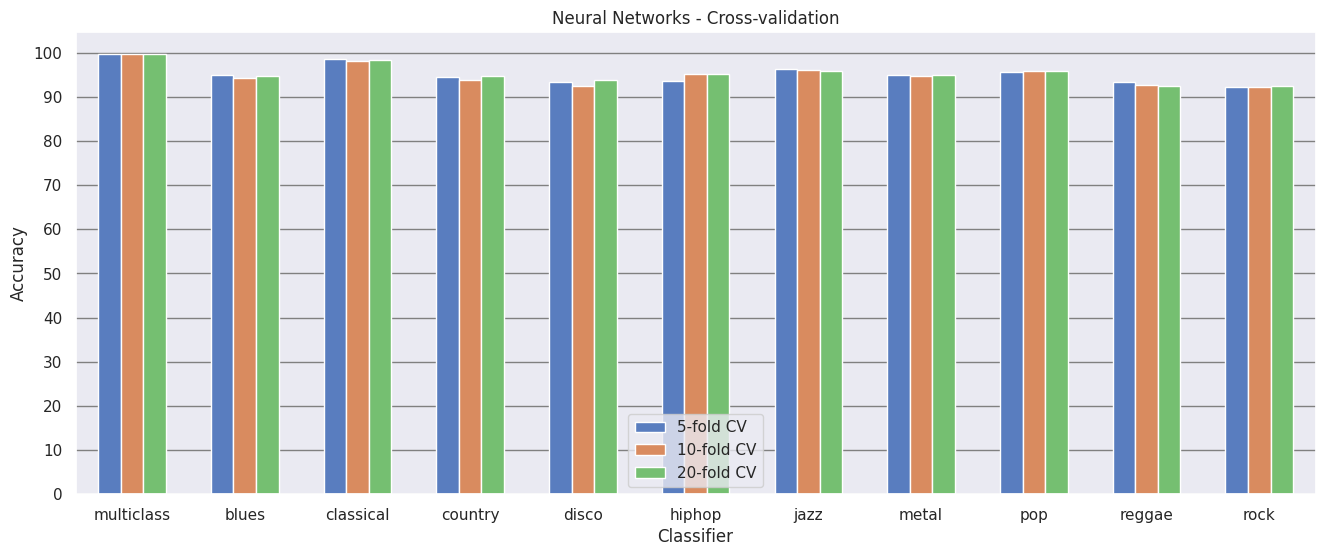

In [19]:
sp_results = []

for fold in folds:
    # Multiclass classifier
    accuracy = cross_validate_multi(X, y_ohe, fold, models['multiclass'])
    sp_results.append(('multiclass', accuracy*100, f'{fold}-fold CV'))
    
    # Binary classifiers
    for genre in genres:
        Xi, yi = balance_classes(X, y, genre)
        accuracy = cross_validate_binary(Xi, yi, fold, models[genre])
        sp_results.append((genre, accuracy*100, f'{fold}-fold CV'))
    
# Plot
results_df = pd.DataFrame(sp_results, columns=('label', 'accuracy', 'size'))   
plot_evaluation_results(results_df, "Neural Networks - Cross-validation")

# Multiclass confusion matrix

In [22]:
from lib import plot_confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.25, random_state=0)
y_pred = models['multiclass'](X_test)
y_pred = np.rint(y_pred.numpy())
plot_confusion_matrix(y_test, y_pred, genres)

ValueError: multilabel-indicator is not supported